In [60]:
import cv2
import numpy as np
import imageio

class Brick:
    x_center = 0
    y_center = 0
    pixel_width = 0
    pixel_height = 0
    rotation_degrees = 0.0
    
'''
https://github.com/alexleavitt/uscplayspokemon/blob/master/tommycam.py
'''
def get_video_capture_frame(video_capture_url_jpg_str):
    img_request = imageio.imread(video_capture_url_jpg_str)#[:,:,::-1] #JPG to BGR
    if (img_request is None) or (not img_request.shape):
        print('No image')
        return False, None
    return True, img_request

'''
https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
'''
def threshold_frame(img_frame, min_threshold):
    ret, thresholded_frame = cv2.threshold(img_frame, min_threshold, 255, cv2.THRESH_BINARY)
    return thresholded_frame


'''
https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed
'''
def remove_noise(img_frame):
    result = img_frame
    result = cv2.bilateralFilter(result,16,32,32) 
    
    kernel = np.ones((2, 2),np.uint8)
    result = cv2.morphologyEx(result, cv2.MORPH_OPEN, kernel) 
    
    kernel = np.ones((9, 9),np.uint8)
    result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel)
   
    result = cv2.bilateralFilter(result,3,16,16)
    return result


def filter_max_rgb(img_frame):
    (B, G, R) = cv2.split(img_frame)
    M = np.maximum(np.maximum(R, G), B)
    R[R < M] = 0
    G[G < M] = 0
    B[B < M] = 0
    result = cv2.merge([B, G, R])
    return result
'''
https://docs.opencv.org/master/df/d9d/tutorial_py_colorspaces.html
https://stackoverflow.com/questions/56905592/automatic-contrast-and-brightness-adjustment-of-a-color-photo-of-a-sheet-of-pape????
'''
def blue_color_mask(img_frame):
    result = img_frame       
#    result = cv2.convertScaleAbs(result, alpha=1.95, beta=0) 
    result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([50,50,80])
    upper_blue = np.array([140,255,255])
    result = cv2.inRange(result, lower_blue, upper_blue)

    ret, result = cv2.threshold(result, 50, 255, cv2.THRESH_BINARY)
    return result

def filter_blue_bricks(img_frame):
    frame = img_frame
    frame = blue_color_mask(frame)
    frame = remove_noise(frame)
    blue_brick_arr = find_brick_centers(frame) 
    return blue_brick_arr, frame

def filter_red_bricks(img_frame):
    result = img_frame
    # result = filter_excess_red_frame(img_frame)
    result = threshold_frame(result, 200)
    #result = remove_noise(result)
    result = find_brick_centers(result)    
    return result

def find_brick_centers(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brick_arr = []
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        if(pixel_areal > 1500):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            rectangle_w_rotation = cv2.minAreaRect(contour)
            brick.pixel_width = rectangle_w_rotation[1][0]
            brick.pixel_height = rectangle_w_rotation[1][1]
            brick.rotation_degrees = rectangle_w_rotation[2]
            #box_points = cv2.cv.BoxPoints(rectangle_w_rotation)
            #print(rectangle_w_rotation)
            print(brick.rotation_degrees)
            #print(brick.pixel_width)
            #print(brick.pixel_height)
            brick_arr.append(brick)
            # frame = cv2.circle(frame,(cx, cy),10,(0,255,0))
            # cv2.imshow('blue', frame)
        elif(pixel_areal > 600):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            brick_arr.append(brick)
            #result = cv2.circle(result,(cx, cy),5,(0,255,0))
    return brick_arr

In [61]:
#from vision_util import *
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [70]:
ret, cam = get_video_capture_frame('http://192.168.1.103/image.jpg')

(285, 600, 3)


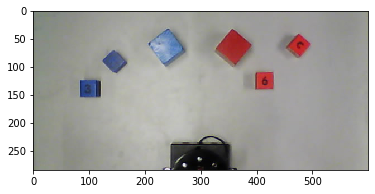

In [71]:
img = cam[75:cam.shape[0]-140+20, 35:cam.shape[1]-5]
print(img.shape)
plt.imshow(img)

(285, 600, 3)


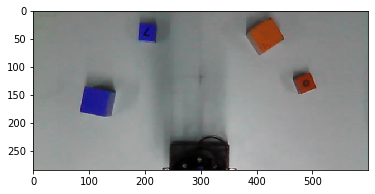

In [78]:
def edge(img_frame):
    frame = img_frame
    frame = cv2.Canny(img_frame, threshold1=0,threshold2=90)
    return frame

def lines(img_frame, im2):
    frame = img_frame
    lines = cv2.HoughLines(frame, rho=1, theta=1, threshold=20)
    for rho,theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(x0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(x0 - 1000*(a))
        
        cv2.line(im2, (x1,y1),(x2,y2),(0,255,255),2)
        
    return im2
img = cam[75:cam.shape[0]-140+20, 35:cam.shape[1]-5]
print(img.shape)

frame = edge(img)
#frame = lines(frame, img)
cv2.line(img, (50,0),(50,200),(0,255,255),2)
plt.imshow(img)

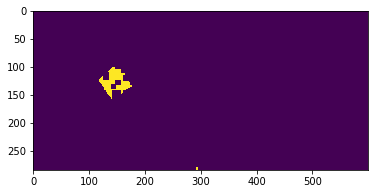

In [17]:

def red_color_mask(img_frame):
    frame = img_frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_red = np.array([140,140,0])
    upper_red = np.array([255,255,255])
    frame = cv2.inRange(frame, lower_red, upper_red)

    ret, frame = cv2.threshold(frame, 50, 255, cv2.THRESH_BINARY)
    return frame

def filter_red_bricks(img_frame):
    frame = img_frame
    frame = red_color_mask(frame)
    frame = remove_noise(frame)
    return frame

def find_bricks(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brick_arr = []
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        if(pixel_areal > 600):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            rectangle_w_rotation = cv2.minAreaRect(contour)
            brick.pixel_width = rectangle_w_rotation[1][0]
            brick.pixel_height = rectangle_w_rotation[1][1]
            brick.rotation_degrees = rectangle_w_rotation[2]
            print(brick.rotation_degrees)
            brick_arr.append(brick)
            text_offset = 30
            
    return brick_arr

frame = filter_red_bricks(img)

plt.imshow(frame)

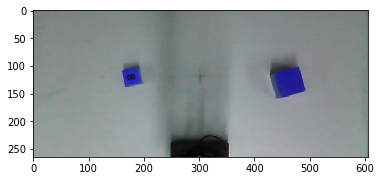

In [21]:
def find_bricks(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brick_arr = []
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        if(pixel_areal > 600):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            rectangle_w_rotation = cv2.minAreaRect(contour)
            brick.pixel_width = rectangle_w_rotation[1][0]
            brick.pixel_height = rectangle_w_rotation[1][1]
            brick.rotation_degrees = rectangle_w_rotation[2]
            print(brick.rotation_degrees)
            #print(brick.pixel_width)
            #print(brick.pixel_height)
            brick_arr.append(brick)
            text_offset = 30
            
    return brick_arr

def plot_brick_data(brick_arr, img_frame):
    frame = img_frame
    for contour in bricks_arr:
        frame = cv2.putText(img=frame,
        text='{:.0f}deg'.format(brick.rotation_degrees),
        org=(brick.x_center + text_offset, brick.y_center - text_offset),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(155, 255, 255),
        thickness=3) 
    return frame

def filter_blue_bricks(img_frame):
    frame = img_frame
    frame = blue_color_mask(frame)
    frame = remove_noise(frame)
    blue_brick_arr = find_bricks(frame) 
    return blue_brick_arr

arr = filter_blue_bricks(img)

img = plot_brick_data(arr, img)
plt.imshow(img)

In [49]:
def init_get_ref_pixel_width(img_frame):
    return 42
    

    

SyntaxError: invalid syntax (<ipython-input-49-ef7621b3574d>, line 1)

First the image is cropped to avoid noise outside of the table. The Crustcrawler has a base with the a width of 11.5 cm. In order to later translate the pixel width of the image into centimeter we are going to use it for calibration. This could also be done with another distinct visual marker.

In [1]:
class Crustcrawler:
    x1 = 0
    x2 = 0
    base_pixel_width = 0

'''
Hue mask
'''
def crustcrawler_mask(img_frame):
    result = img_frame       
    result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
    lower_rgb = np.array([0,0,0])
    upper_rgb = np.array([120,120,90])
    result = cv2.inRange(result, lower_rgb, upper_rgb)

    ret, result = cv2.threshold(result, 50, 255, cv2.THRESH_BINARY)
    return result

'''
'''
def filter_crustcrawler(img_frame):
    frame = img_frame
    frame = crustcrawler_mask(frame)
    frame = vs.remove_noise(frame)
    return frame

def find_crustcrawler_pixel_width(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    crustcrawler = Crustcrawler()
    
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        rectangle_w_rotation = cv2.minAreaRect(contour) # use the one without rotation
        crustcrawler.x1 = rectangle_w_rotation[0][0]
        crustcrawler.x2 = rectangle_w_rotation[1][0]
        print(rectangle_w_rotation)    
    
    return crustcrawler, frame
    
crust = filter_crustcrawler(crop)
print(base.x2)
base, frame = find_crustcrawler_pixel_width(crust)

#rgb_img = cv2.cvtColor(binary_img, cv.CV_GRAY2RGB)
cv2.line(frame, (int(base.x1),150), (int(base.x2), 150), (255,255,255), thickness=8)
print(base)
plt.imshow(frame)

NameError: name 'crop' is not defined

In [ ]:
cropped_img = img[52:img.shape[0]-197, 28:img.shape[1]-2]

plt.imshow(cropped_img)

In [ ]:
plt.imshow(img2)

In [ ]:
plt.imshow(img3)

In [ ]:
def find_brick_centers(img_frame):
    frame = img_frame
    contours, hierarchy = cv2.findContours(frame.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    brick_arr = []
    for contour in contours:
        pixel_areal = cv2.contourArea(contour)
        if(pixel_areal > 1500):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            rectangle_w_rotation = cv2.minAreaRect(contour)
            brick.pixel_width = rectangle_w_rotation[1][0]
            brick.pixel_height = rectangle_w_rotation[1][1]
            brick.rotation_degrees = rectangle_w_rotation[2]
            #box_points = cv2.cv.BoxPoints(rectangle_w_rotation)
            #print(rectangle_w_rotation)
            print(brick.rotation_degrees)
            #print(brick.pixel_width)
            #print(brick.pixel_height)
            brick_arr.append(brick)
            # frame = cv2.circle(frame,(cx, cy),10,(0,255,0))
            # cv2.imshow('blue', frame)
        elif(pixel_areal > 600):
            brick = Brick()
            M = cv2.moments(contour)
            brick.x_center = int(M['m10']/M['m00'])
            brick.y_center = int(M['m01']/M['m00'])
            brick_arr.append(brick)
            #result = cv2.circle(result,(cx, cy),5,(0,255,0))
    return brick_arr